In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf  # Statsmodels is a Python module for statistics

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF 
from statsmodels.stats.anova import anova_lm

from ISLP import load_data    # ISLP library for the book, it has built in functions and methods to build models 
from ISLP.models import (ModelSpec as MS, summarize , poly) # It also has built-in data that can be loaded

import matplotlib as mpl


#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'


sns.set(style="white") # Plot parameters defined globally
plt.style.use("seaborn-v0_8-white")

## 11) Investigating t-statistics for the null hypothesis $H_0: \beta = 0$ in simple Linear Regression without an intercept

In [2]:
np.random.seed(1)

x = np.random.normal(size = 100) # generates a random distribution with a size 100
y = 2 * x + np.random.normal(size = 100)

df = pd.DataFrame({'x': x, 'y': y}) # make a data frame that will be useful later 

df.head()

,x,y
0,1.624345,2.801562
1,-0.611756,0.000995
2,-0.528172,-0.652852
3,-1.072969,-1.552359
4,0.865408,0.635903


### a)

In [3]:
SLRM = smf.ols(formula = 'y ~ x + 0', data = df)

SLRM_fit = SLRM.fit()

print(SLRM_fit.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.796
Method:                 Least Squares   F-statistic:                              391.7
Date:                Tue, 19 Dec 2023   Prob (F-statistic):                    3.46e-36
Time:                        21:02:54   Log-Likelihood:                         -135.67
No. Observations:                 100   AIC:                                      273.3
Df Residuals:                      99   BIC:                                      275.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------


### The model: $$ \hat{y} = \hat{\beta}_x\, x, \quad\quad \hat{\beta}_x = 2.1067 $$

In [7]:
print(f'Coefficient estimate using the least square regression is {SLRM_fit.params[0]:.4f}')
print(f'Standard Error for the slope is {SLRM_fit.bse[0]:.4f}') # using .bse we get standard errors 

Coefficient estimate using the least square regression is 2.1067
Standard Error for the slope is 0.1064


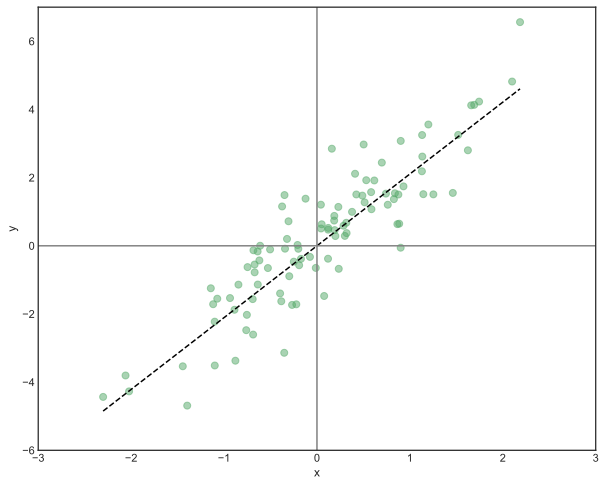

In [9]:
# Lets plot x vs y and the OLS line 

df = pd.DataFrame({'x': x, 'y': y})

fig, ax = plt.subplots(figsize = (10,8))

def lsline(axis, X, b, m, *args, **kwargs):
    
    "Add a line with slope m and intercept b to ax"
    xval = np.linspace(X.min(),X.max(),50)
    
    axis = plt.plot(xval, b + m * xval, *args, **kwargs)


sns.regplot(data = df, x = 'x', y = 'y', ax = ax, scatter_kws={'color': 'g', 's': 50, "alpha": 0.5}, fit_reg=False) # if fit_reg = True 
# an automatic regression line, together with its errors is drawn together with the scatter data, option True additional option for this line
#can be provided via line_kws={'color': 'r'}
lsline(ax, x, 0, SLRM_fit.params[0], color = 'black', ls = 'dashed') # least squares fit line 

ax.set_xlim(-3,3)
ax.set_ylim(-6,7)
ax.axhline(0,color = 'gray')
ax.axvline(0,color = 'gray')

### p-value for the null hypotesis is essentially zero therefore there is a statistically significant relationship between x and y. 

### b) Regress x onto y

In [10]:
SLRMxy_fit = smf.ols(formula = 'x ~ y + 0', data = df).fit()

print(SLRMxy_fit.summary())

                                 OLS Regression Results                                
Dep. Variable:                      x   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.796
Method:                 Least Squares   F-statistic:                              391.7
Date:                Tue, 19 Dec 2023   Prob (F-statistic):                    3.46e-36
Time:                        21:11:11   Log-Likelihood:                         -49.891
No. Observations:                 100   AIC:                                      101.8
Df Residuals:                      99   BIC:                                      104.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### The model: $$ \hat{x} = \hat{\beta}_y\, y, \quad\quad \hat{\beta}_y = 0.3789$$
### SE of this coefficient estimate is 0.018. The t-statistic is equal to 19.792 and the p-value is close to 0. We can therefore reject the null hypothesis and conclude that there is evidence for a relationship between x and y.

### c) p-values and $R^2$ score of both regression coefficients are the same. However the coefficient estimates are not close to reciprocal of each other as one might expect: 
### $$  \hat{\beta}_y  \neq \frac{1}{\hat{\beta}_x}$$

In [12]:
print(f'Expected beta_y estimate {1/SLRM_fit.params[0]:.4f} vs actual {SLRMxy_fit.params[0]:.4f}')

Expected beta_y estimate 0.4747 vs actual 0.3789


### From the conceptual exercises we know that Linear Regression without an intercept leads to the following estimates for both coefficients 

### $$ \hat{\beta}_x = \frac{\sum x_i y_i}{\sum x_i^2},\quad \hat{\beta}_y = \frac{\sum x_i y_i}{\sum y_i^2}\quad \longrightarrow \hat{\beta}_x \hat{\beta}_y = \frac{(\sum x_i y_i)^2}{\sum x_i^2\sum y_i^2} = R^2, $$

### which implies that reciprical coefficients will differ by a factor of variance explained ($R^2$ which is equal for both models) 

### $$  \hat{\beta}_x = \frac{1}{ \hat{\beta}_y}\, R^2$$

### Only in the limit where $R^2 \to 1$, the coefficients can be made equal. 

### d) We first simply the formula for SE using $\hat{\beta}  = \sum x_i y_i / \sum x_i^2$:

### $$ \textrm{SE}(\hat{\beta}) = \sqrt{\frac{\sum (y_i - 2 \hat{\beta} x_i y_i + \hat{\beta}^2 x_i^2)}{(n-1)\sum x_i^2}} = \frac{1}{\sqrt{n-1}}\sqrt{\frac{\sum y_i^2}{\sum x_i^2} - \hat{\beta}^2} = \frac{1}{\sqrt{(n-1)}\sum x_i^2}\sqrt{\sum y_i^2\sum x_i^2 - (\sum x_i y_i)^2 }$$

### plugging the above expression to 

### $$ t = \frac{\hat{\beta}}{\textrm{SE}(\hat{\beta})} $$

### gives 

### $$ t = \frac{\sqrt{(n-1)} \sum x_i y_i }{\sqrt{\sum y_i^2\sum x_i^2 - (\sum x_i y_i)^2}}$$

### e) It is clear from the expression above that t statistic is symmetric under $x_i \rightarrow y_i$ such that t-statistic for the regression y onto x is equivalent to the t-stat. for regression x onto y. 

### f) Equivalence of t-statistics for y onto x vs x onto y in the presence of an intercept

In [13]:
SLRMyx = smf.ols(formula = 'y ~ x', data = df).fit()

SLRMxy = smf.ols(formula = 'x ~ y', data = df).fit()

In [14]:

if SLRMyx.tvalues[1] == SLRMxy.tvalues[1]: # [1] grabs the t-value for the slope whereas [0] picks up t-value for the intercept

    print(f't- statistics for the null hypotesis for beta_1 = 0 is the same for both models')

else: 

    print(f't- statistics for the null hypotesis for beta_1 = 0 are not equivalent')

t- statistics for the null hypotesis for beta_1 = 0 is the same for both models


## **References**

### Introduction to Statistical Learning with Python: 

- [Introduction to Statistical Learning with Python](https://www.statlearning.com/). 